<center>
# Machine Learning
## Project 2
## EM for Mixture Model
### Dimitris Papatheodorou 3130162


#### Libraries

In [76]:
import numpy as np
from numpy import random
import numpy.matlib as mat
import scipy.linalg as LA
from random import random
from random import randint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

old_settings = np.seterr(all='ignore')

#### Load MNIST data for handwritten digits

In [2]:
def load_mnist_data(type_, K=10):
    X = np.loadtxt("mnist/"+type_+"0.txt")
    T = np.zeros((X.shape[0], K))
    T[:,0] = 1
    for i in range(1,10):
        X_ = np.loadtxt("mnist/"+type_+"%d.txt" % i)
        T_ = np.zeros((X_.shape[0], K))
        T_[:,i] = 1
        X = np.concatenate((X, X_), axis=0)
        T = np.concatenate((T, T_), axis=0)
    return X, T

X_train, T_train = load_mnist_data("train")
X_test, T_test = load_mnist_data("test")

An original handwritten digit of the dataset.

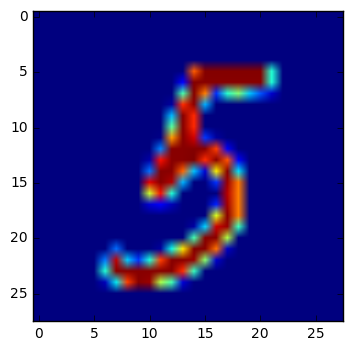

In [3]:
plt.imshow(X_train[35550,:].reshape((28,28)))

#### Convert pixel values to binary

In [4]:
X_train[X_train < 3] = 0
X_train[X_train > 1] = 1
X_test[X_test < 3] = 0
X_test[X_test > 0] = 1

The same digit after the binary transformation.

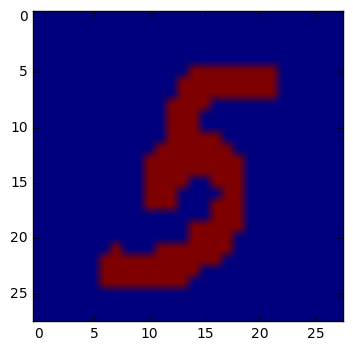

In [5]:
plt.imshow(X_train[35550,:].reshape((28,28)))

This looks conceptually cleaner.

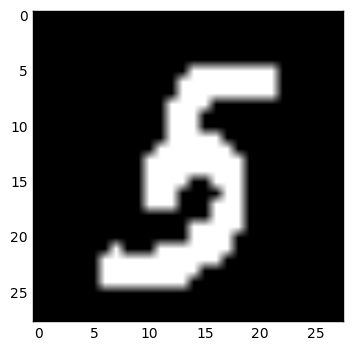

In [6]:
plt.imshow(X_train[35550,:].reshape((28,28)), cmap = cm.Greys_r)

## <center> Model description </center>

Given a set of training data **$X$** of size *$N \times D$*, we assume that each **$x \in X$** has been produced *independently* from the Bernoulli mixture:
$$p(\mathbf{x}) = \sum_{k=1}^K \pi_k \prod_{d=1}^D \mu_{kd}^{\mathbf{x}_d}(1-\mu_{kd})^{1-\mathbf{x}_d}$$

- $\pi_k$ being the **mixing coefficient**, the a priori probability of class $\pi_k = p(z_k=1)$, $z_k$ binary random variable, subject to $0 \leq \pi_k \leq 1$ and $\sum_{k=1}^K \pi_k = 1$.
- $\prod_{d=1}^D \mu_{kd}^{\mathbf{x}_d}(1-\mu_{kd})^{1-\mathbf{x}_d}$, a mixture of $K$ Bernoulli distributions, being the **mixture component**, the conditional distribution $p(\mathbf{x}|k)$.

As $\pi_k$ is the prior probability of $z_k = 1$, we denote $\gamma(z_k)$ as the corresponding posterior probability once we have observed $\mathbf{x}$:
$$\gamma(z_k) = p(z_k=1|\mathbf{x}) = \frac{\pi_k \prod_{d=1}^D \mu_{kd}^{\mathbf{x}_d}(1-\mu_{kd})^{1-\mathbf{x}_d}}{\sum_{j=1}^K\pi_j \prod_{d=1}^D \mu_{jd}^{\mathbf{x}_d}(1-\mu_{jd})^{1-\mathbf{x}_d}}$$

The Bernoulli mixture joint distribution (likelihood):
$$p(\mathbf{X}|\pi,\mu) = \prod_{n=1}^N \sum_{k=1}^K \pi_k \prod_{d=1}^D \mu_{kd}^{\mathbf{x}_{nd}}(1-\mu_{kd})^{1-\mathbf{x}_{nd}}$$

This is hard computionally speaking, so we use instead the complete data set $\mathbf{\{X,Z\}}$, considering that Z, the hidden variable, is given. This may not be true literally, but it helps in the computation process afterwards. <br>
The new **likelihood** is:
$$p(\mathbf{X}, \mathbf{Z}|\pi,\mu) = \prod_{n=1}^N \prod_{k=1}^K \Big(\pi_k \prod_{d=1}^D \mu_{kd}^{\mathbf{x}_{nd}}(1-\mu_{kd})^{1-\mathbf{x}_{nd}}\Big)^{z_{nk}}$$

We need to maximize the **complete log likelihood** of the distribution:
$$\mathcal{L}_c(\pi,\mu) = \sum_{n=1}^N \sum_{k=1}^K z_{nk} \left\{ \log \pi_k + \sum_{d=1}^D \mathbf{x}_{nd} \Big(\log \mu_{kd} + (1 − x_{nd}) \log (1 − \mu_{kd})\Big) \right\}$$

But that is impossible because we don't know \mathbf{Z}. So we compute the **expected complete log likelihood**:
$$Q(\mu, \pi) = \sum_{n=1}^N \sum_{k=1}^K \gamma(z_{nk}) \left\{ \log \pi_k + \sum_{d=1}^D \mathbf{x}_{nd} \Big(\log \mu_{kd} + (1 − x_{nd}) \log (1 − \mu_{kd})\Big) \right\}$$

Q is concave so it's optimal parameters, that maximize Q, are found where its partial derivatives is equal to 0:
$$\begin{align}
\frac{\partial Q}{\partial \mu_{kd}} &= 0 \Rightarrow \mu_{kd} = \frac{\sum_{n=1}^N \gamma(z_{nk}) x_{nd}}{\gamma(z_{nk})} \\
\frac{\partial Q}{\partial \pi_{k}} &= 0 \Rightarrow \pi_{k} = \frac{\sum_{n=1}^N \gamma(z_{nk})}{N}
\end{align}
$$

Then we use the **Expectation-Maximization (EM)** algorithm to iteratively achieve the maximum (incomplete) likelihood based on the calculation formulas of the optimal parameters we computed above:
1. Initiliazation of parameters
2. Expectation step: calculate $\gamma(z_{nk})$
3. Maximization step: calculate $\mu_{kd}$ and $\pi_{k}$
4. Convergence and error check: if $L(\mu_{kd}, \pi_{k}) ^{new} < L(\mu_{kd}, \pi_{k}) ^{old}$ then _error_ and if $|L(\mu_{kd}, \pi_{k}) ^{new} - L(\mu_{kd}, \pi_{k}) ^{old}| < \epsilon$, we've achieved convergence.


We use this model for each class in order to classify the binary images of handwritten digits.
So mixture for each class $c$ is:
$$p(\mathbf{x}|c) = \sum_{k=1}^{Kc} \pi_k^{(c)} \prod_{d=1}^D (\mu_{kd}^{(c)})^{\mathbf{x}_d}(1-\mu_{kd}^{(c)})^{1-\mathbf{x}_d}$$

The prediction of the model is done using the Bayes rule for computing the maximum posterior probility of each class:
$$ \DeclareMathOperator*{\argmax}{arg\,max}
c^∗(x) = \argmax_c \Big\{ \log p(c) + \log \sum_{k=1}^{Kc} \pi_k^{(c)} \prod_{d=1}^D (\mu_{kd}^{(c)})^{\mathbf{x}_d}(1-\mu_{kd}^{(c)})^{1-\mathbf{x}_d} \Big\}$$

where $p(c)$ is the a priori probability of the class $c$.


In the implementation, for vectorizing the computations and for numerical stability, the **logsumexp** and the **explog** tricks where used.


In [77]:
class BernoulliMixtureClassifier:
  
    def __init__(self, class_num=10, mixture_components_num=10, max_iter=300, tol=1e-6):
        self.max_iter = max_iter
        self.tol = tol
        self.K = mixture_components_num
        self.C = class_num
        self.pC = np.zeros((self.C,1))
        self.mu = []
        self.pi = []
        self.r = 1e-10
        
    def fit(self, X, T):
        self.X = X
        self.T = T
        self.N = X.shape[0]
        self.D = X.shape[1]
        self.lkhs = np.empty((self.C,1))
        Ic = np.transpose(np.nonzero(T == 1))
        for c in range(self.C):
            Ix = np.transpose(np.nonzero(Ic[:,1] == c))
            Xc = X[Ix.flatten(),:]
            self.pC[c,0] = float(Xc.shape[0]) / self.N
            self.lkhs[c,0] = self.expectation_maximization(Xc, c)
        
    def predict(self, X):
        T_tests = np.empty((X.shape[0], self.C))
        for c in range(self.C):
            logbern = np.log(self.pi[c]) + X @ np.log(self.mu[c].T) + (1-X) @ np.log((1-self.mu[c].T))
            # get ready for numerically stable calculations
            M = np.max(logbern, axis=1)
            M = M[:, np.newaxis]
            sumbern = np.sum(np.exp(logbern - M), axis=1, keepdims=True)
            # to prevent underflows
            # these kind of operations also reduce the error
            sumbern[sumbern < self.r] = self.r
            # apply logsumexp trick
            bayes = np.log(self.pC[c]) + M + np.log(sumbern)
            T_tests[:,c] = bayes.flatten()
        return np.argmax(T_tests, axis=1), T_tests
        
    def expectation_maximization(self, X, c):
        # Parameter initialization
        self.pi.append(np.full((1,self.K), 1./self.K))
        self.mu.append(
        np.random.uniform(0.4, 0.60000001, (self.K, self.D)))
        L_old = -9999999999999999999 # float('-Inf')

        for it in range(1, self.max_iter+1):
            # Expectation
            gamma = self.expectation(X, c)
            
            # Incomplete log likelihood
            L_new = self.likelihood()
            print('Iteration: %d, log likelihood: %f\n' % (it, L_new))
            
            # Maximization
            self.maximization(X, gamma, c)
            
            # error check
            if L_new - L_old <= -1e-10:
                print("Error: new likelihood less than old.")
                break
                
            # convergence check
            if np.abs((L_new - L_old)/L_old) < self.tol:
                L_old = L_new
                break
                
            L_old = L_new
        return L_old
            
    def expectation(self, X, c):
        # responsibilities               
        # apply the logexp trick
        logbern = np.log(self.pi[c]) + X @ np.log(self.mu[c].T) + (1-X) @ np.log((1-self.mu[c].T))
        # get ready for numerically stable calculations
        M = np.max(logbern, axis=1)
        M = M[:, np.newaxis]
        # apply logsumexp trick
        # this will be needed for the likelihood calculation, so keep it for later
        sumbern = np.sum(np.exp(logbern - M), axis=1, keepdims=True)
        sumbern[sumbern < self.r] = self.r
        self.sumlogbern = M + np.log(sumbern)
        gamma = np.exp(logbern - self.sumlogbern)
        gamma[gamma <= self.r] = self.r
        return gamma
                
    def maximization(self, X, gamma, c):               
        gammasum = np.sum(gamma, axis=0, keepdims=True)
        # μ
        self.mu[c] = gamma.T @ X / gammasum.T
        self.mu[c][self.mu[c] < self.r] = self.r
        self.mu[c][self.mu[c] >= 1] = 1 - self.r
        # π
        self.pi[c] = gammasum / X.shape[0]
        self.pi[c][self.pi[c] < self.r] = self.r
        self.pi[c][self.pi[c] >= 1] = 1 - self.r
        
    def likelihood(self):
        likelihood = np.sum(self.sumlogbern)
        return likelihood
    
    def softmax(Y):
        assert len(Y.shape) == 2
        M = np.max(Y, axis=1)
        M = M[:, np.newaxis] # necessary step to do broadcasting
        e_x = np.exp(Y - M)
        div = np.sum(e_x, axis=1)
        div = div[:, np.newaxis]
        return e_x / div

###################################################################################################
# FOR DEBUG - for loops - very slow and inelegant
# copy paste then if the respective function

# expectation
#         N = X.shape[0] 
#         gam = np.empty((N, self.K))
#         divsum = np.zeros((N,1))
#         for n in range(N):
#             for k in range(self.K):
#                 prod = 1
#                 for d in range(self.D):
#                     prod *= self.mu[k,d]**X[n,d] * (1-self.mu[k,d])**(1-X[n,d])
#                 gam[n,k] = self.pi[0,k] * prod
#                 divsum[n,0] += gam[n,k]
#         gam /= divsum
#         print(np.max(np.abs(gamma-gam)))

# maximization
#         N = X.shape[0]
        # μ calculation
#         mu = np.zeros_like(self.mu)
#         gamsum = np.zeros((self.K,1))
#         for k in range(self.K):
#             for n in range(N):
#                 for d in range(self.D):
#                     mu[k,d] += gamma[n,k] * X[n,d]
#                 gamsum[k,0] += gamma[n,k]
#         mu /= gamsum
#         # π calculation
#         pi = np.zeros_like(self.pi)
#         for k in range(self.K):
#             for n in range(N):
#                 pi[0,k] += gamma[n,k] / N
#         print(np.max(np.abs(self.mu-mu)))
#         print(np.max(np.abs(self.pi-pi)))

# log likelihood
#         N = X.shape[0]
#         k_sum = np.zeros((N,1))
#         for n in range(N):
#             for k in range(self.K):
#                 d_prod = 1
#                 for d in range(self.D):
#                     d_prod *= self.mu[k,d]**X[n,d] * (1-self.mu[k,d])**(1-X[n,d])
#                 k_sum[n,0] += self.pi[0,k] * d_prod
#         lkh = np.sum(np.log(k_sum))
#         print(likelihood - lkh)

In [78]:
def test_model(model, X_test, T_test, print_error=False):
    T, Y = model.predict(X_test)
    T_true = np.argmax(T_test, axis=1)
    error = np.mean(T_true != T)
    if print_error:
        print("Accuracy Error: %g%%" % (error*100))
    return error

### Train the model with different number of components

In [ ]:
models = []
for nc in range(6):
    K = 2**nc
    print("\nBERNOULLI MIXTURE WITH K = %d COMPONENTS\n" % (K))
    model = BernoulliMixtureClassifier(max_iter=200, mixture_components_num=K)  # 1, 2, 4, 8, 16, 32
    model.fit(X_train, T_train)
    models.append(model)

### Test the models

In [80]:
errors = []
for model in models:
    err = test_model(model, X_test, T_test, False)
    print("K = %d: Error = %g%%" % (model.K, err*100))
    errors.append(err)

K = 1: Error = 15.76%
K = 2: Error = 12.09%
K = 4: Error = 8.84%
K = 8: Error = 7.23%
K = 16: Error = 5.99%
K = 32: Error = 5.39%


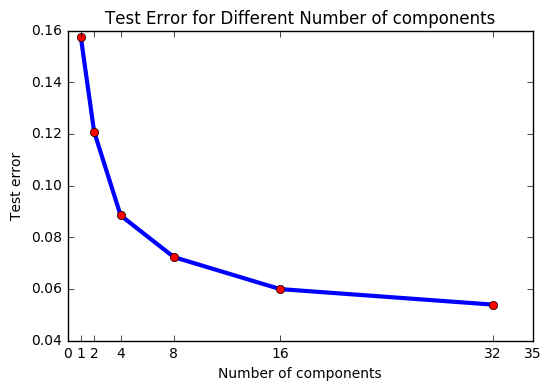

In [81]:
plt.plot([1, 2, 4, 8, 16, 32], errors, linewidth=3)
plt.plot([1, 2, 4, 8, 16, 32], errors, 'ro')
plt.xticks([0, 1, 2, 4, 8, 16, 32, 35])
plt.xlabel('Number of components')
plt.ylabel('Test error')
plt.title('Test Error for Different Number of components')

### Plot the ghostly figures of the digits generated by the trained parameters of the models with K=1 and K=32

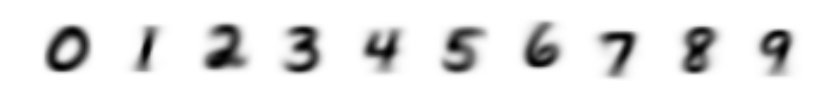

In [82]:
fig = plt.figure(1)
for i in range(models[0].K):
    for c in range(models[0].C):
        plt.subplot(models[0].K ,models[0].C, c+1)  
        plt.imshow(1-models[0].mu[c][i,:].reshape((28,28)), cmap = cm.Greys_r)
        plt.axis('off') 
fig.set_size_inches(10, 15, forward=True)
plt.show()

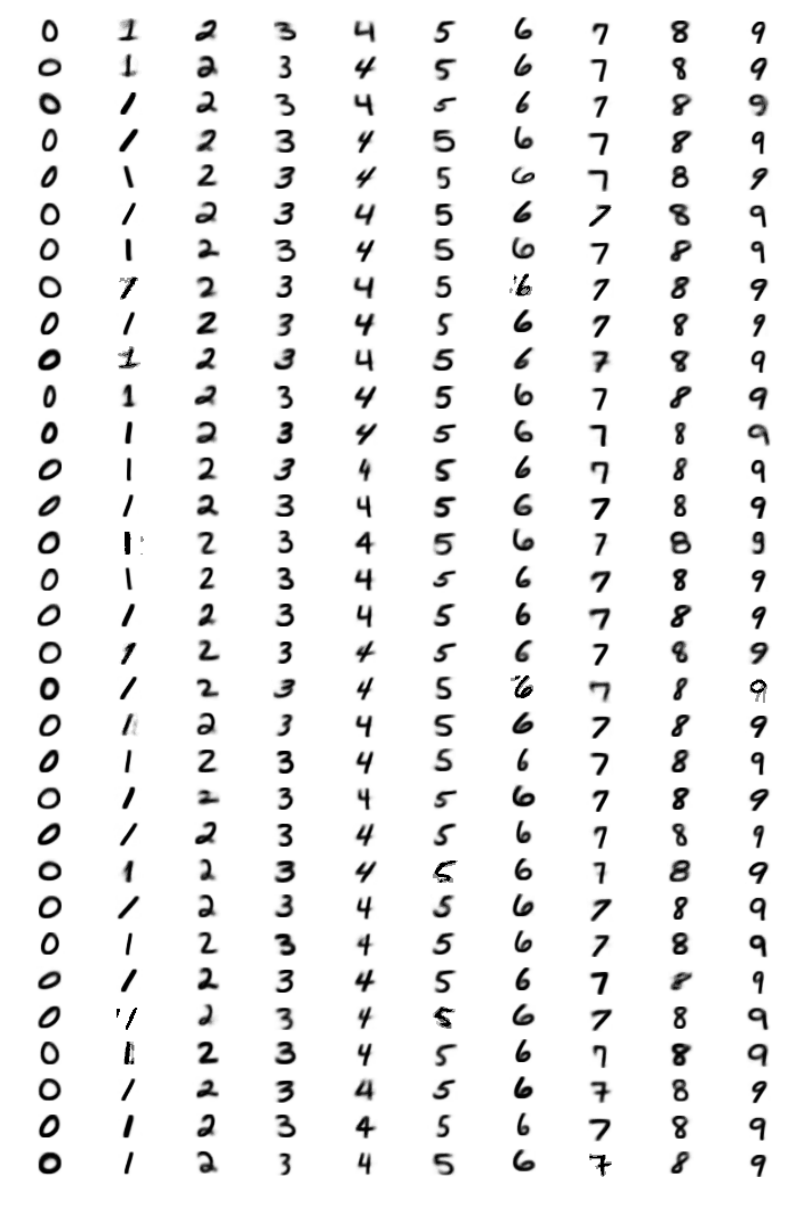

In [83]:
fig1 = plt.figure(1)
for i in range(models[-1].K):
    for c in range(models[-1].C):
        plt.subplot(models[-1].K ,models[-1].C, models[-1].C*i+c+1)  
        plt.imshow(1-models[-1].mu[c][i,:].reshape((28,28)), cmap = cm.Greys_r)
        plt.axis('off') 
fig1.set_size_inches(10, 15, forward=True)
plt.show()

### Generate and plot some fantasy random digits from the distribution (with K=1 and K=32)

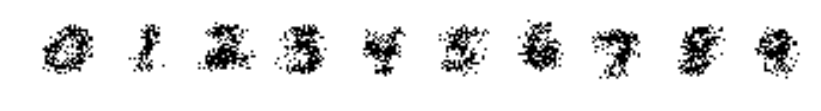

In [84]:
fig3 = plt.figure(1)
for i in range(models[0].K):
    for c in range(models[0].C):
        plt.subplot(models[0].K ,models[0].C, models[0].C*i+c+1)   
        U = np.random.random((1,models[0].D))
        Xf = np.array(U > models[0].mu[c][i,:])
        plt.imshow(Xf.reshape((28,28)), cmap = cm.Greys_r)
        plt.axis('off')  
fig3.set_size_inches(10, 15, forward=True)
plt.show()

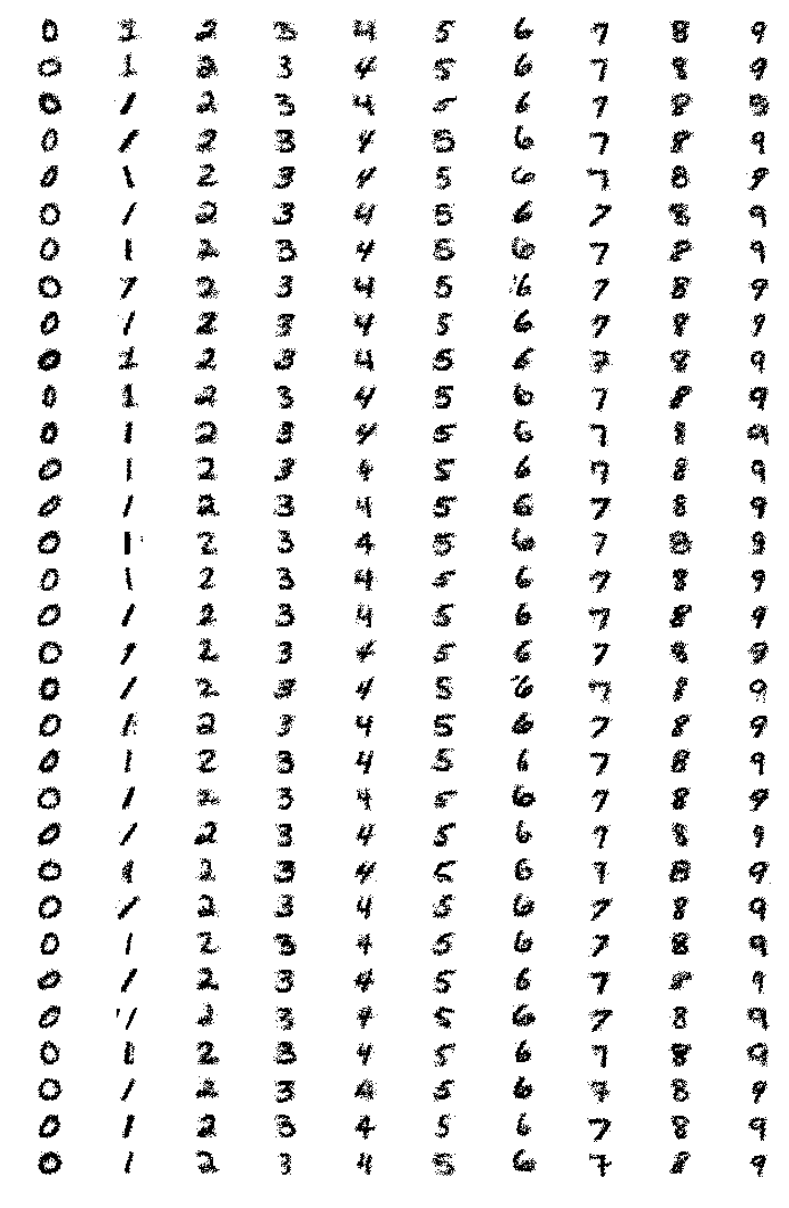

In [85]:
fig4 = plt.figure(1)
for i in range(models[-1].K):
    for c in range(models[-1].C):
        plt.subplot(models[-1].K ,models[-1].C, models[-1].C*i+c+1)   
        U = np.random.random((1,models[-1].D))
        Xf = np.array(U > models[-1].mu[c][i,:])
        plt.imshow(Xf.reshape((28,28)), cmap = cm.Greys_r)
        plt.axis('off') 
fig4.set_size_inches(10, 15, forward=True)
plt.show()